<a href="https://colab.research.google.com/github/justin-g-wang/Heart-Attack-Predictor/blob/main/heart_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS105 Final Project (Team 16)

## Project Introduction
<p align = "justify"> For this project, our goal is to classify the possible complications of a myocardial infarction (MI), or heart attack based on various patient attributes. The dataset we will be using is from the UCI Machine Learning Repository, and it contains data from 1992-1995 for 1700 patients in Krasnoyarsk, Russia. There are 111 patient attributes and 12 possible complications of MI included in the dataset. The techniques that will be used for our classification models are Random Forest and kNN. After creating two different classication models, we will compare and analyze them.

**Dataset**
https://archive.ics.uci.edu/dataset/579/myocardial+infarction+complications

**Slides Link**
https://docs.google.com/presentation/d/12m9FrRQW_VIChSy69mjaiSLjll-lKaTHF1AiOW5k3R0/edit?usp=sharing

## Data Cleaning
The data set was cleaned before performing any exploratory data analysis. Five columns with greater than 50% NA values were dropped because they would not be useful to our data analysis. Missing values for the remaining numerical variables were filled in using mean imputation, and missing values for categorical variables were filled in using mode imputation. Random Forest and KNN were the unsupervised learning methods used to classify possible complications of MI. The feature variables used for this were chosen by selecting the input variable with the greatest Pearson’s correlation with a given complication. K-Means clustering was also used to visualize groupings in our data.

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# fetch dataset
myocardial_infarction_complications = fetch_ucirepo(id=579)

# data (as pandas dataframes)
X = myocardial_infarction_complications.data.features
y = myocardial_infarction_complications.data.targets

# metadata
print(myocardial_infarction_complications.metadata)

# variable information
# print(myocardial_infarction_complications.variables)

{'uci_id': 579, 'name': 'Myocardial infarction complications', 'repository_url': 'https://archive.ics.uci.edu/dataset/579/myocardial+infarction+complications', 'data_url': 'https://archive.ics.uci.edu/static/public/579/data.csv', 'abstract': 'Prediction of myocardial infarction complications', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1700, 'num_features': 111, 'feature_types': ['Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK', 'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN', 'LET_IS'], 'index_col': ['ID'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C53P5M', 'creators': ['S.E. Golovenkin', 'V.A. Shulman', 'D.A. Rossiev', 'P.A. Shesternya', 'S.Yu. Nikulina', 'Yu.V. Orlova', 'V.F. Voino-Yasenetsky'], 'intro_paper': {'tit

In [ ]:
#created a data frame with UCI dataset
mi_df = pd.DataFrame(data= myocardial_infarction_complications.data.original)
print(mi_df.head())

   ID   AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST  IBS_NASL   GB  \
0   1  77.0    1       2.0        1.0        1.0       2.0       NaN  3.0   
1   2  55.0    1       1.0        0.0        0.0       0.0       0.0  0.0   
2   3  52.0    1       0.0        0.0        0.0       2.0       NaN  2.0   
3   4  68.0    0       0.0        0.0        0.0       2.0       NaN  2.0   
4   5  60.0    1       0.0        0.0        0.0       2.0       NaN  3.0   

   SIM_GIPERT  ...  JELUD_TAH  FIBR_JELUD  A_V_BLOK  OTEK_LANC  RAZRIV  \
0         0.0  ...          0           0         0          0       0   
1         0.0  ...          0           0         0          0       0   
2         0.0  ...          0           0         0          0       0   
3         0.0  ...          0           0         0          0       0   
4         0.0  ...          0           0         0          0       0   

   DRESSLER  ZSN  REC_IM  P_IM_STEN  LET_IS  
0         0    0       0          0       0  


In [ ]:
# data cleaning

# find the sum of NA's in each column
na_counts = mi_df.isna().sum()

# calculate NA % in columns
na_p = (na_counts / len(mi_df)) * 100

# find columns with more than 50% NA values
na_over_50_columns = na_p[na_p > 50].index.tolist()

# remove columns from data frame
mi_df = mi_df.drop(columns = na_p[na_p > 50].index)

#removed ID column
mi_df = mi_df.drop(columns = ["ID"])

# removed columns:
# IBS_NASL: Heredity on CHD 0: isn't burdened 1: burdened
# S_AD_KBRIG: Systolic blood pressure according to Emergency Cardiology Team
# D_AD_KBRIG: Diastolic blood pressure according to Emergency Cardiology Team
# KFK_BLOOD: Serum CPK content
# ID: Record ID; not related to patient

In [ ]:
# mean imputation for missing values for integer variables (real attributes)

column_names = [ 'AGE', 'S_AD_ORIT', 'D_AD_ORIT', 'K_BLOOD', 'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'L_BLOOD', 'ROE']

# find column indices
column_idx = [mi_df.columns.get_loc(col) for col in column_names]

# get mean of columns
column_means = mi_df.iloc[:, column_idx].mean()

# mode imputation for categorical variables
# find indices for all other columns
mode_im_columns = [mi_df.columns.get_loc(col) for col in mi_df.columns if col not in mi_df.columns[column_idx]]

# mode imputation
column_modes = mi_df.iloc[:, mode_im_columns].mode().iloc[0]
mi_df.iloc[:, mode_im_columns] = mi_df.iloc[:, mode_im_columns].fillna(column_modes)

print(mi_df.head())
print(mi_df.isna().any().any())

    AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST   GB  SIM_GIPERT  \
0  77.0    1       2.0        1.0        1.0       2.0  3.0         0.0   
1  55.0    1       1.0        0.0        0.0       0.0  0.0         0.0   
2  52.0    1       0.0        0.0        0.0       2.0  2.0         0.0   
3  68.0    0       0.0        0.0        0.0       2.0  2.0         0.0   
4  60.0    1       0.0        0.0        0.0       2.0  3.0         0.0   

   DLIT_AG  ZSN_A  ...  JELUD_TAH  FIBR_JELUD  A_V_BLOK  OTEK_LANC  RAZRIV  \
0      7.0    0.0  ...          0           0         0          0       0   
1      0.0    0.0  ...          0           0         0          0       0   
2      2.0    0.0  ...          0           0         0          0       0   
3      3.0    1.0  ...          0           0         0          0       0   
4      7.0    0.0  ...          0           0         0          0       0   

   DRESSLER  ZSN  REC_IM  P_IM_STEN  LET_IS  
0         0    0       0          

**Explanation:** We cleaned our data by disregarding 4 columns (`IBS_NASL`, `S_AD_KBRIG`, `D_AD_KBRIG`, `KFK_BLOOD`) because of they had more than 50% of Na values. We also dropped the `ID` column because its data was not related to the patient. We then filled in the missing values in our dataset using mean and mode imputation for numerical and categorical data respectively.

## EDA


In [ ]:
# Possible Complications
complications = ["FIBR_PREDS", "PREDS_TAH", "JELUD_TAH", "FIBR_JELUD", "A_V_BLOK", "OTEK_LANC", "RAZRIV", "DRESSLER", "ZSN", "REC_IM", "P_IM_STEN"]

# Tables showing amounts of 1's and 0's for each complication
for complication in complications:
    print(pd.crosstab(index=mi_df[complication], columns="count", margins=True))


col_0       count   All
FIBR_PREDS             
0            1530  1530
1             170   170
All          1700  1700
col_0      count   All
PREDS_TAH             
0           1680  1680
1             20    20
All         1700  1700
col_0      count   All
JELUD_TAH             
0           1658  1658
1             42    42
All         1700  1700
col_0       count   All
FIBR_JELUD             
0            1629  1629
1              71    71
All          1700  1700
col_0     count   All
A_V_BLOK             
0          1643  1643
1            57    57
All        1700  1700
col_0      count   All
OTEK_LANC             
0           1541  1541
1            159   159
All         1700  1700
col_0   count   All
RAZRIV             
0        1646  1646
1          54    54
All      1700  1700
col_0     count   All
DRESSLER             
0          1625  1625
1            75    75
All        1700  1700
col_0  count   All
ZSN               
0       1306  1306
1        394   394
All     1700  1700


ZSN           394
FIBR_PREDS    170
OTEK_LANC     159
REC_IM        159
P_IM_STEN     148
DRESSLER       75
FIBR_JELUD     71
A_V_BLOK       57
RAZRIV         54
JELUD_TAH      42
PREDS_TAH      20
dtype: int64


Text(0.5, 1.0, 'Frequency of Complications')

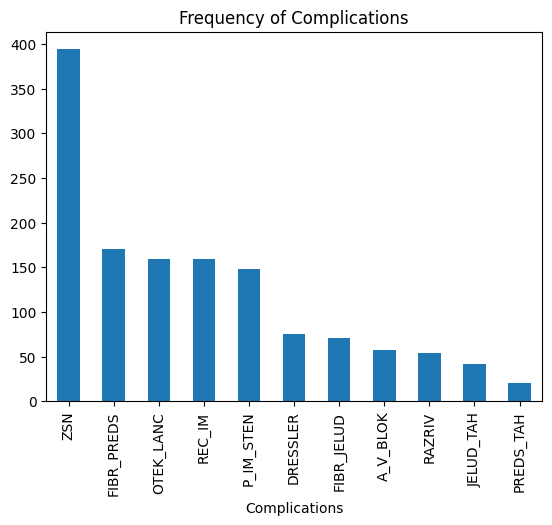

In [ ]:
#BAR CHART
#counting number of people that had each complication
counts = mi_df[complications].sum().sort_values(ascending=False)
print(counts)

#plotted bar chart
counts.plot.bar()

#changed x-axis label
plt.xlabel('Complications')

#created a title
plt.title('Frequency of Complications')

**Explanation:** The bar chart above displays the frequency of each complication. Chronic heart failure (ZSN) is the most frequent complication among the patients in the data, followed by atrial fibrillation (FIBR_PREDS), pulmonary edema (OTEK_LANC), relapse of MI (REC_IM), and post-infarction angina (P_IM_STEN). This shows that when one goes through MI, chronic heart failure is more likely to occur than the other complications.

1    1065
0     635
Name: SEX, dtype: int64


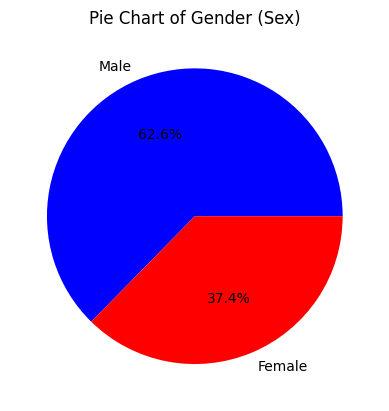

In [ ]:
#PIE CHART
#counted the amount of patients that were male (1) and female (0)
gender_counts = mi_df['SEX'].value_counts()
print(gender_counts)

#created a pie chart
plt.pie(gender_counts, labels = ['Male', 'Female'], colors = ['blue', 'red'], autopct='%1.1f%%')

#created a title
plt.title('Pie Chart of Gender (Sex)')
plt.show()

**Explanation** The pie chart above displays the percentage of gender that have gone through a MI. We can see that through this graph, males are more likely to undergo a MI then females.

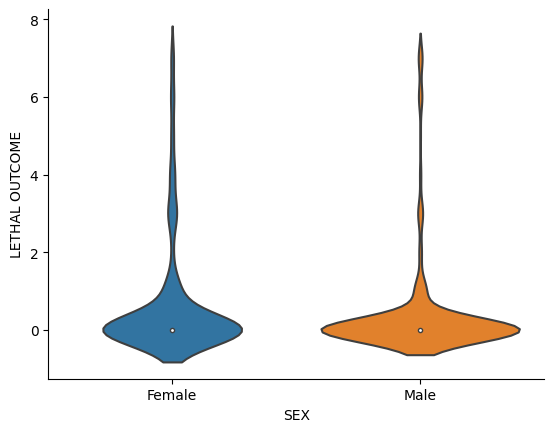

In [ ]:
#VIOLIN PLOT
#created a violin plot with gender and lethal outcome
violin_plot = sns.violinplot(data = mi_df , x= 'SEX', y= 'LET_IS')

#changed y-axis label
violin_plot.set_ylabel('LETHAL OUTCOME')

#changed x values on the x-axis (changed it from 1 and 0 to male and female)
plt.xticks([0, 1], ["Female", "Male"])
sns.despine()

**Explanation** From the violin plot above, we can come up with two conclusions. We can see that females has a wider base and not that much of a peak which can imply that the lethal outcomes have a broader spread, is wider, and is less skewed than males. On the other hand, for males it is taller and narrower meaning that the Lethal Outcomes values are more concentrated with fewer outliers.

<Axes: ylabel='ZSN_A'>

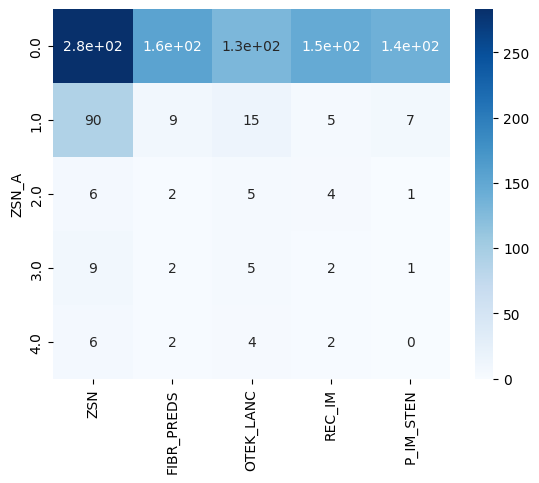

In [ ]:
#HEAT MAP
#took the top complications from the bar chart
top_complications = ['ZSN', 'FIBR_PREDS', 'OTEK_LANC', 'REC_IM', 'P_IM_STEN']

#grouped by the top complications byy ZSN_A (presence of chronic heart failure in their anamnesis)
tab = mi_df.groupby('ZSN_A')[top_complications].sum()

#cretaed a heat maps of input variables vs. complications
sns.heatmap(tab, cmap = "Blues", annot = True)

**Explanation** From the heat map above we can see different things. We can see that FIBR_PREDS has the highest sum in the ZSN column if we don't take into account it being compared to itself. We can also see that there is an inverse relationship between ZSN and the complications. As ZSN increases, the complications decrease

0       77.0
1       55.0
2       52.0
3       68.0
4       60.0
        ... 
1695    77.0
1696    70.0
1697    55.0
1698    79.0
1699    63.0
Name: AGE, Length: 1700, dtype: float64


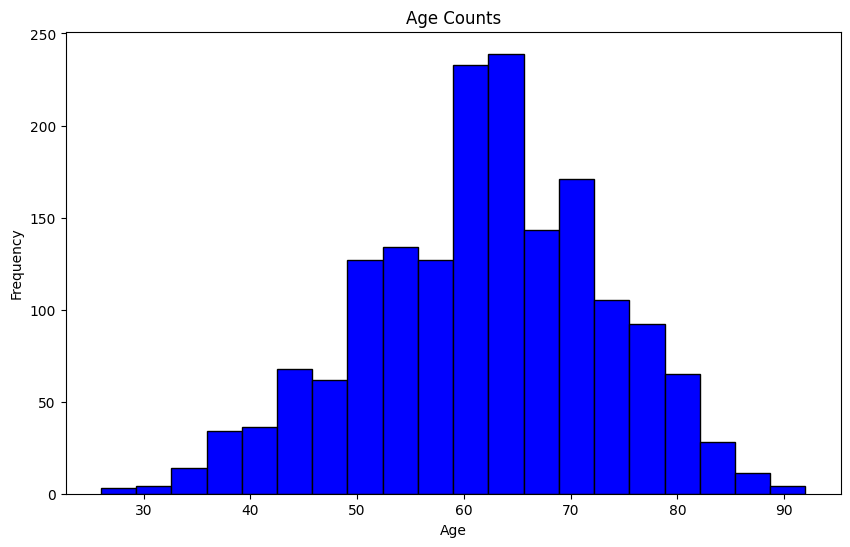

In [ ]:
#HISTOGRAM
#took out age column from dataset
age_counts = mi_df["AGE"]
print(age_counts)

#changed size of the histogram)
plt.figure(figsize=(10, 6))

#ploted the patients ages
plt.hist(age_counts, bins=20, color='blue', edgecolor='black')  # Adjust the number of bins as needed

#changed title
plt.title('Age Counts')

#changed axises labels
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

**Explanation** The graph above is a histogram that displays the count of age. We are able to show the count of people at certain ages. We can see that in the graph, ages 60-65 has the most amount of people.

## Pearson's Correlation

In [ ]:
# pearson correlation

#made a copy of the data frame
corr_df = mi_df.copy()
r = corr_df.corr()

# Define the target variables to exclude
exclude_variables = ['ZSN', 'FIBR_PREDS', 'OTEK_LANC', 'REC_IM', 'P_IM_STEN']

# Exclude the specified variables from the list of all variables
other_variables = [var for var in r.index if var not in exclude_variables]

# Calculate the absolute correlations with the target variables for all other variables
correlations_with_target = r.loc[other_variables, exclude_variables].abs()

# Find the variable with the highest correlation for each target variable
highest_correlation_variables = correlations_with_target.idxmax()
highest_correlation_values = correlations_with_target.max()

# Print or display the results for each target variable
for target_variable in exclude_variables:
    highest_correlation_variable = highest_correlation_variables[target_variable]
    highest_correlation_value = highest_correlation_values[target_variable]

    print(f"For '{target_variable}', the variable with the highest correlation (excluding itself) is '{highest_correlation_variable}' "
          f"with a correlation of {highest_correlation_value:.2f}")

For 'ZSN', the variable with the highest correlation (excluding itself) is 'ZSN_A' with a correlation of 0.17
For 'FIBR_PREDS', the variable with the highest correlation (excluding itself) is 'n_r_ecg_p_05' with a correlation of 0.21
For 'OTEK_LANC', the variable with the highest correlation (excluding itself) is 'NITR_S' with a correlation of 0.32
For 'REC_IM', the variable with the highest correlation (excluding itself) is 'R_AB_3_n' with a correlation of 0.18
For 'P_IM_STEN', the variable with the highest correlation (excluding itself) is 'FK_STENOK' with a correlation of 0.10


**Explanation:**
The pairwise Pearson’s correlation was also calculated for all columns in the dataset, excluding the ID of a patient. We used these values to determine the input variable that had the greatest correlation with our target variables. Although these had the greatest correlation with our target variables, all except for the correlation between OTEK_LANC and NITR_S were below 0.3, which can be interpreted as very little correlation. Nevertheless, we used these input variables in our classification models, as other variables had even smaller Pearson’s correlation values.


## Random Forest Classification
We used a Random Forest model to classify the top five most frequent MI complications in our data set: chronic heart failure (ZSN), atrial fibrillation (FIBR_PREDS), pulmonary edema (OTEK_LANC), relapse of MI (REC_IM), and post-infarction angina (P_IM_STEN). The model was trained using the features with the highest Pearson’s correlation coefficient with our five MI complications of interest. These features are presence of chronic heart failure in the anamnesis (ZSN_A), paroxysms of atrial fibrillation on ECG at the time of hospital admission (n_r_ecg_p_0), sse of liquid nitrates in the ICU (NITR_S),  relapse of the pain in the third day of the hospital period (R_AB_3_n), and the functional class of angina pectoris in the last year (FK_STENOK). The test size was 30%, and the training size was 70%, with a random state of 50 to ensure the code reproduces the same result each time it is run. After training the model, we output each model's accuracy, precision, recall, and confusion matrix.

0.8117647058823529
              precision    recall  f1-score   support

           0       0.81      0.98      0.89       393
           1       0.78      0.25      0.38       117

    accuracy                           0.81       510
   macro avg       0.80      0.61      0.63       510
weighted avg       0.81      0.81      0.77       510



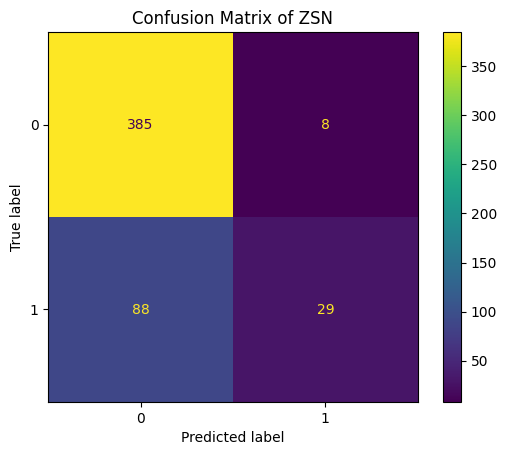

In [ ]:
#identified x and y (x = features and y = target variable)
x = mi_df[['ZSN_A', 'n_r_ecg_p_05', 'NITR_S', 'R_AB_3_n', 'FK_STENOK']]
y = mi_df['ZSN']

#callled the random forest classifier
rf = RandomForestClassifier()

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)
rf.fit(x_train, y_train)

#predicted test x
y_pred = rf.predict(x_test)

#calculated accuracy score with the tests of x and y
t_zsn_accuracy_score = rf.score(x_test, y_test)
#train_zsn_acc_score = rf.score(x_train, y_train)

#created a classification report with predicted y and test y
class_report = classification_report(y_test, y_pred)

#created a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()

#added title to the confusion matrix
plt.title("Confusion Matrix of ZSN")

#printed out accuracy score and classification report
print(t_zsn_accuracy_score)
print(class_report)
plt.show()

**Explanation:** The confusion matrix for chronic heart failure (`ZSN`) as a complication of MI shows that the model had an accuracy of 0.81, a precision of  0.78, and a recall of 0.24. Based on the accuracy, the classification model was correct most of the time, but the high precision and low recall showcases that it was more likely to make more false negatives.

0.8960784313725491
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       462
           1       0.14      0.02      0.04        48

    accuracy                           0.90       510
   macro avg       0.52      0.50      0.49       510
weighted avg       0.83      0.90      0.86       510



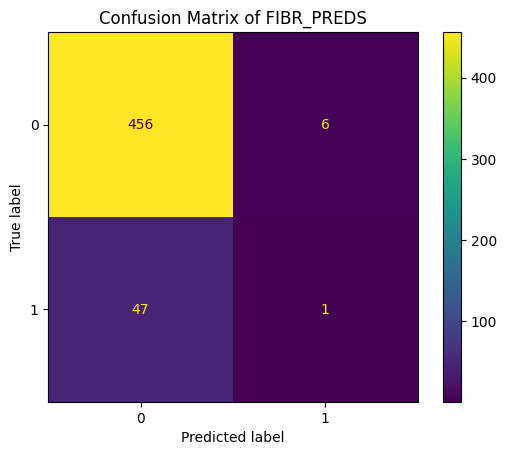

In [ ]:
#changed target value for y
y = mi_df['FIBR_PREDS']

rf = RandomForestClassifier()

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)

rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

accuracy_score = rf.score(x_test, y_test)

class_report = classification_report(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix).plot()

plt.title("Confusion Matrix of FIBR_PREDS")

print(accuracy_score)
print(class_report)
plt.show()

**Explanation:** The confusion matrix for atrial fibrillation (`FIBR_PREDS`) as a complication of MI shows that the model had an accuracy of 0.89, a precision of  0.29, and a recall of 0.08. The high accuracy indicates that the model was correct most of the time, but the low precision and recall show that contrary to what the accuracy measurement tells us, the model was not actually performing accurately.

0.9196078431372549
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       469
           1       0.50      0.10      0.16        41

    accuracy                           0.92       510
   macro avg       0.71      0.54      0.56       510
weighted avg       0.89      0.92      0.89       510



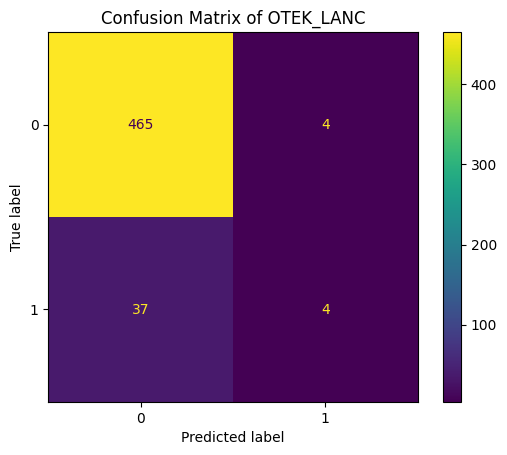

In [ ]:
#changed target value for y
y = mi_df['OTEK_LANC']

rf = RandomForestClassifier()

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)

rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

accuracy_score = rf.score(x_test, y_test)

class_report = classification_report(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix).plot()

plt.title("Confusion Matrix of OTEK_LANC")

print(accuracy_score)
print(class_report)
plt.show()

**Explanation:** The confusion matrix above for pulmonary edema (`OTEK_LANC`) shows that the model had an accuracy of 0.92, a precision of 0.50, and a recall of 0.12. Although it had high accuracy, it had a moderately low precision and low recall.

0.9019607843137255
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       463
           1       0.00      0.00      0.00        47

    accuracy                           0.90       510
   macro avg       0.45      0.50      0.47       510
weighted avg       0.82      0.90      0.86       510



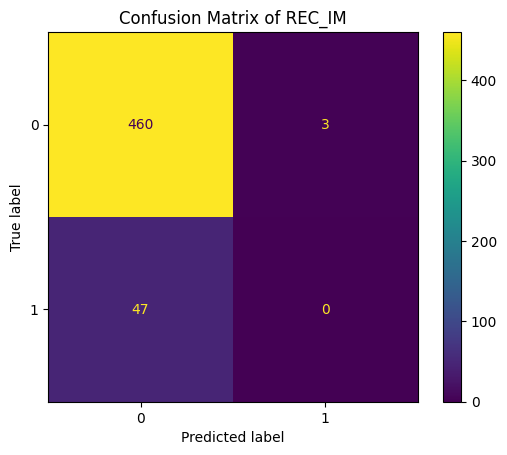

In [ ]:
#changed target value for y
y = mi_df['REC_IM']

rf = RandomForestClassifier()

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)

rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

accuracy_score = rf.score(x_test, y_test)

class_report = classification_report(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix).plot()

plt.title("Confusion Matrix of REC_IM")

print(accuracy_score)
print(class_report)
plt.show()

**Explanation:** The confusion matrix relapse of myocardial infarction (`REC_IM`) had an accuracy of 0.90, a precision of 0.00, and a recall of 0.00. Even though it has a high accuracy, the precision and recall values of 0.00 indicate that this is not a good model for classifying post-infarction angina as a complication of MI.

0.9058823529411765
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       462
           1       0.00      0.00      0.00        48

    accuracy                           0.91       510
   macro avg       0.45      0.50      0.48       510
weighted avg       0.82      0.91      0.86       510



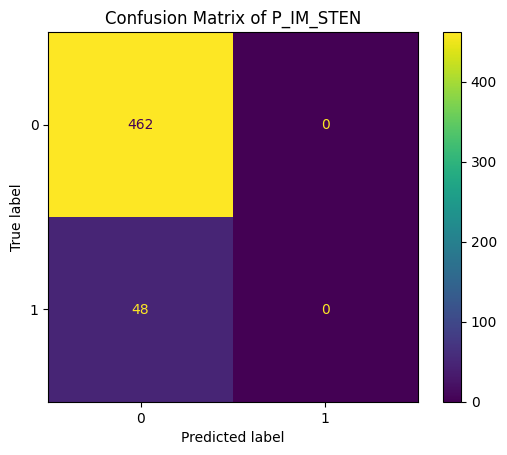

In [ ]:
#changed target value for y
y = mi_df['P_IM_STEN']

rf = RandomForestClassifier()

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)

rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

accuracy_score = rf.score(x_test, y_test)

class_report = classification_report(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix).plot()

plt.title("Confusion Matrix of P_IM_STEN")

print(accuracy_score)
print(class_report)
plt.show()

**Explanation:** The confusion matrix for post infarction angina (`P_IM_STEN`) was similar to the one for REC_IM. The model also had a high accuracy of 0.91, but a precision and recall of 0.00, showing that it performed poorly in the classification of P_IM_STEN.

Overall, the classification models using Random Forest and our selected feature variables did not yield good results for classifying MI complications. They all had high accuracy but overall low precision and recall, except for the model for ZSN, which had a high precision. The high accuracy values for all models are due to the fact that a large portion of the test and training data included patients who did not have the complication, which the models correctly predicted. However, the goal was to classify the complications, so accuracy is not a good measure of how well the models perform. Instead, the focus should be on obtaining a high recall, which is preferred for classifying what complication a patient might have after an MI.

## K-Nearest Neighbors Classification

classification report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       263
           1       0.76      0.29      0.42        77

    accuracy                           0.82       340
   macro avg       0.79      0.63      0.65       340
weighted avg       0.81      0.82      0.78       340



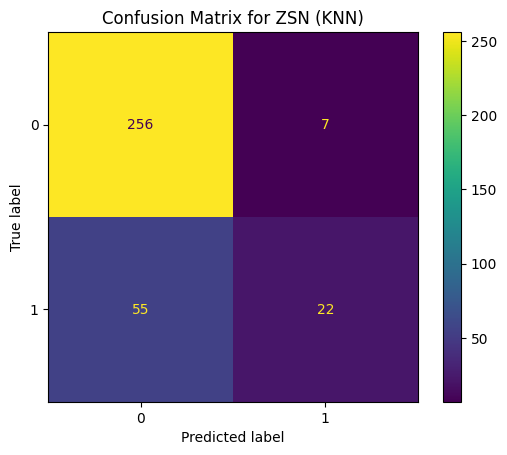

In [ ]:
data = mi_df

# ZSN as the target variable
target_variable = ['ZSN']

# used the same features as Random Forest models
features = ['ZSN_A', 'n_r_ecg_p_05', 'NITR_S', 'R_AB_3_n', 'FK_STENOK']

X_train, X_test, y_train, y_test = train_test_split(data[features], data[target_variable], test_size=0.2, random_state = 50)

# set it to 11 nearest neighbors
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

# predicted the x test
y_pred = knn.predict(X_test)

# created classification report
print('classification report:')
print(classification_report(y_test, y_pred))

# created confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()
plt.title('Confusion Matrix for ZSN (KNN)')
plt.show()

**Explanation:** The confusion matrix above for chronic heart failure (ZSN) as a complication of MI shows that the KNN classification model had an accuracy of 0.82, a precision of  0.76, and a recall of 0.29. The high accuracy tells us that the classification model was correct most of the time, but the moderately high precision and low recall shows that it was more likely to make more false negatives, which is similar to the Random Forest model for ZSN.

classification report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       310
           1       0.43      0.10      0.16        30

    accuracy                           0.91       340
   macro avg       0.67      0.54      0.56       340
weighted avg       0.88      0.91      0.88       340



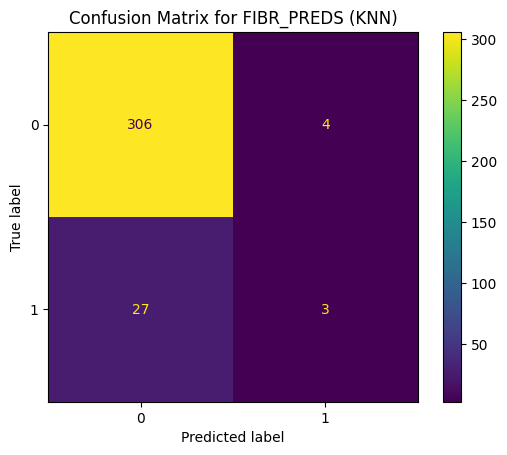

In [ ]:
# changed target variable to FIBR_PREDS
target_variable = ['FIBR_PREDS']

X_train, X_test, y_train, y_test = train_test_split(data[features], data[target_variable], test_size=0.2, random_state = 50)

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('classification report:')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()
plt.title('Confusion Matrix for FIBR_PREDS (KNN)')
plt.show()

**Explanation:** The confusion matrix above for atrial fibrillation (FIBR_PREDS) as a complication of MI shows that the KNN model had an accuracy of 0.91, a precision of  0.43, and a recall of 0.10. The low recall shows that although the model has a high accuracy, the model did not predict the positive cases accurately.

classification report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       309
           1       0.00      0.00      0.00        31

    accuracy                           0.91       340
   macro avg       0.45      0.50      0.48       340
weighted avg       0.83      0.91      0.87       340



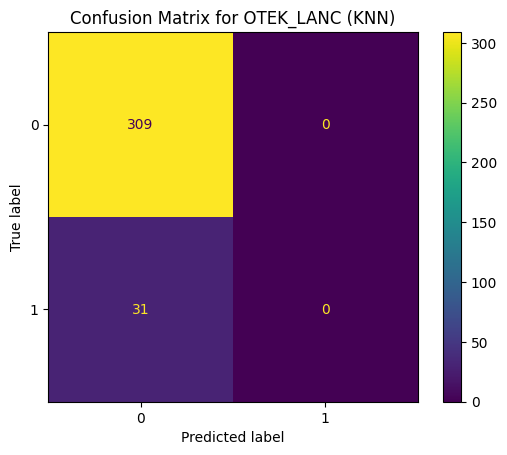

In [ ]:
# changed target variable to OTEK_LANC
target_variable = ['OTEK_LANC']

X_train, X_test, y_train, y_test = train_test_split(data[features], data[target_variable], test_size=0.2, random_state = 50)

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('classification report:')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()
plt.title('Confusion Matrix for OTEK_LANC (KNN)')
plt.show()

**Explanation:** The confusion matrix above for pulmonary edema (OTEK_LANC) shows that the KNN model had an accuracy of 0.91, a precision of 0.00, and a recall of 0.00. Although it had high accuracy, it had precision and recall values of 0.00. In comparison to the Random Forest model for OTEK_LANC, this model performed more poorly.

classification report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       306
           1       0.00      0.00      0.00        34

    accuracy                           0.90       340
   macro avg       0.45      0.50      0.47       340
weighted avg       0.81      0.90      0.85       340



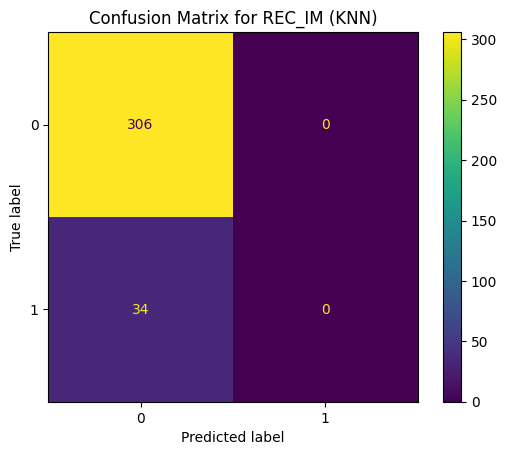

In [ ]:
# changed target variable to REC_IM
target_variable = ['REC_IM']

X_train, X_test, y_train, y_test = train_test_split(data[features], data[target_variable], test_size=0.2, random_state = 50)

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('classification report:')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()
plt.title('Confusion Matrix for REC_IM (KNN)')
plt.show()

**Explanation:** In the confusion matrix above for relapse of myocardial infarction (REC_IM), we can see that the KNN model had an accuracy of 0.90, a precision of 0.00, and a recall of 0.00. This model had the same accuracy, precision, and recall values as the Random Forest model, so neither is better than the other; both performed poorly on the test data.

classification report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       309
           1       0.00      0.00      0.00        31

    accuracy                           0.91       340
   macro avg       0.45      0.50      0.48       340
weighted avg       0.83      0.91      0.87       340



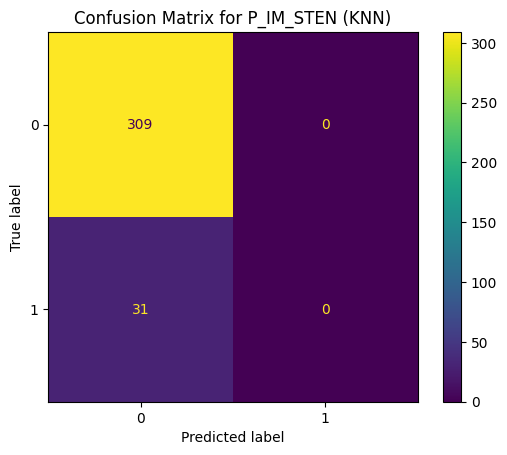

In [ ]:
# changed target variable to P_IM_STEN
target_variable = ['P_IM_STEN']

X_train, X_test, y_train, y_test = train_test_split(data[features], data[target_variable], test_size=0.2, random_state = 50)

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('classification report:')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()
plt.title('Confusion Matrix for P_IM_STEN (KNN)')
plt.show()

**Explanation:** The confusion matrix above for post-infarction angina (P_IM_STEN) was similar to the one for REC_IM with a high accuracy of 0.91 but a precision and recall of 0.00. This model also performed similarly to the Random Forest model for P_IM_STEN.

Regarding accuracy, the Random Forest and KNN models had very similar values. The accuracy of the KNN model for ZSN was greater by 0.01, and the KNN model for FIBR_PREDS was greater by 0.02. The models for both classification methods had the same accuracy for OTEK_LANC, REC_IM, and P_IM_STEN. The precision and recall for both types of classification models are also similar, but the Random Forest model for OTEK_LANC does not have precision and recall values of 0.00, whereas the KNN model does. Since this is the only distinct difference between the two classification methods, the Random Forest models are slightly better in classifying an MI complication. A possible reason for the small precision and recall values is the selection of input variables, which had the largest correlation with the target variables overall but still need to be larger to be statistically significant.

## K-Means Clustering
We used K-Means Clustering to cluster each MI complication using the same feature variables we used for Random Forest classification. To use K-means on our data, we utilized PCA as a dimensionality reduction technique to reduce the number of dimensions to 2 principal components

In [ ]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

kdata = mi_df

# set target and features
features = ['ZSN_A', 'n_r_ecg_p_05', 'NITR_S', 'R_AB_3_n', 'FK_STENOK']
target = 'ZSN'

kClusterData = kdata[features + [target]]


k_range = range(2, 10)
silhouette_scores = []
for k in k_range:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(kClusterData)
  cluster_labels = kmeans.predict(kClusterData)
  silhouette_score_k = silhouette_score(kClusterData, cluster_labels)
  silhouette_scores.append(silhouette_score_k)

# dimensionality reduction with PCA to two principal components
pca = PCA(n_components=2)
kClusterData = pca.fit_transform(kClusterData)

# use k-means clustering
kmeans = KMeans(n_clusters=k)
kmeans.fit(kClusterData)

# get centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# output silhouette score
silhouette_avg = silhouette_score(kClusterData, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.8975732014438884


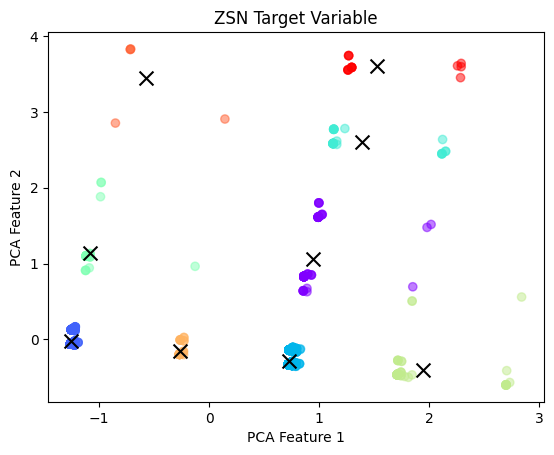

In [ ]:
plt.scatter(kClusterData[:, 0], kClusterData[:, 1], c=labels, cmap='rainbow', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='black')
plt.title('ZSN Target Variable')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

In [ ]:
target = 'FIBR_PREDS'

kClusterData = kdata[features + [target]]


k_range = range(2, 10)
silhouette_scores = []
for k in k_range:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(kClusterData)
  cluster_labels = kmeans.predict(kClusterData)
  silhouette_score_k = silhouette_score(kClusterData, cluster_labels)
  silhouette_scores.append(silhouette_score_k)

pca = PCA(n_components=2)
kClusterData = pca.fit_transform(kClusterData)

kmeans = KMeans(n_clusters=k)
kmeans.fit(kClusterData)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

silhouette_avg = silhouette_score(kClusterData, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.952678385136712


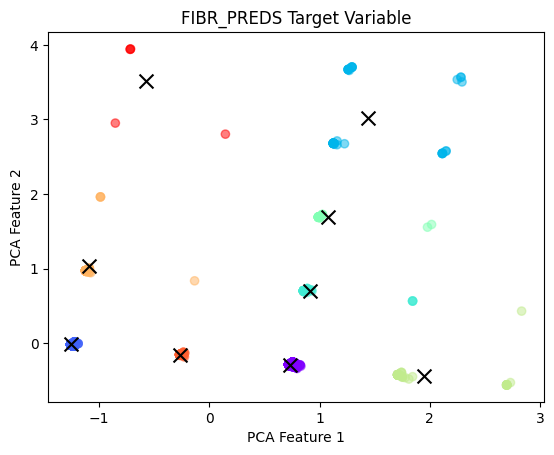

In [ ]:
plt.scatter(kClusterData[:, 0], kClusterData[:, 1], c=labels, cmap='rainbow', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='black')
plt.title('FIBR_PREDS Target Variable')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

Silhouette Score: 0.9468783330670171


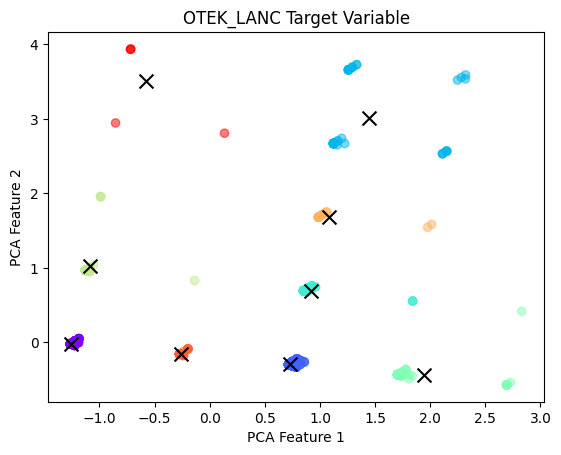

In [ ]:
target = 'OTEK_LANC'

kClusterData = kdata[features + [target]]


k_range = range(2, 10)
silhouette_scores = []
for k in k_range:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(kClusterData)
  cluster_labels = kmeans.predict(kClusterData)
  silhouette_score_k = silhouette_score(kClusterData, cluster_labels)
  silhouette_scores.append(silhouette_score_k)

pca = PCA(n_components=2)
kClusterData = pca.fit_transform(kClusterData)

kmeans = KMeans(n_clusters=k)
kmeans.fit(kClusterData)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

silhouette_avg = silhouette_score(kClusterData, labels)
print(f"Silhouette Score: {silhouette_avg}")

plt.scatter(kClusterData[:, 0], kClusterData[:, 1], c=labels, cmap='rainbow', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='black')
plt.title('OTEK_LANC Target Variable')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

Silhouette Score: 0.9501764967021119


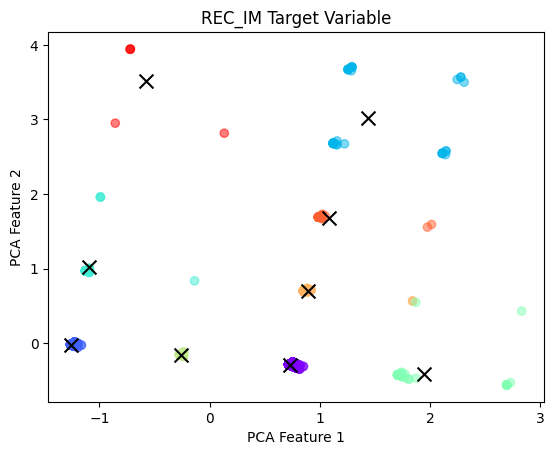

In [ ]:
target = 'REC_IM'

kClusterData = kdata[features + [target]]


k_range = range(2, 10)
silhouette_scores = []
for k in k_range:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(kClusterData)
  cluster_labels = kmeans.predict(kClusterData)
  silhouette_score_k = silhouette_score(kClusterData, cluster_labels)
  silhouette_scores.append(silhouette_score_k)

pca = PCA(n_components=2)
kClusterData = pca.fit_transform(kClusterData)

kmeans = KMeans(n_clusters=k)
kmeans.fit(kClusterData)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

silhouette_avg = silhouette_score(kClusterData, labels)
print(f"Silhouette Score: {silhouette_avg}")

plt.scatter(kClusterData[:, 0], kClusterData[:, 1], c=labels, cmap='rainbow', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='black')
plt.title('REC_IM Target Variable')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

Silhouette Score: 0.9480783914727472


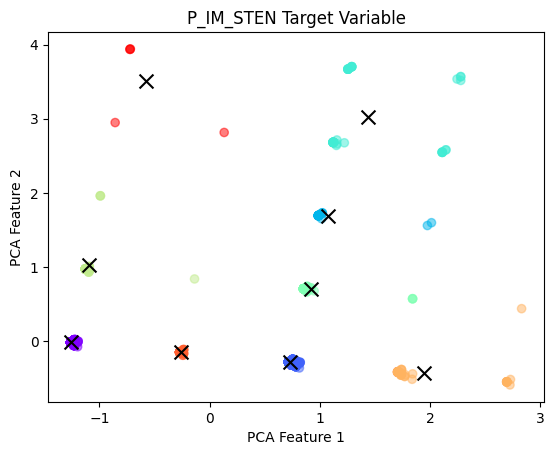

In [ ]:
target = 'P_IM_STEN'

kClusterData = kdata[features + [target]]


k_range = range(2, 10)
silhouette_scores = []
for k in k_range:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(kClusterData)
  cluster_labels = kmeans.predict(kClusterData)
  silhouette_score_k = silhouette_score(kClusterData, cluster_labels)
  silhouette_scores.append(silhouette_score_k)

pca = PCA(n_components=2)
kClusterData = pca.fit_transform(kClusterData)

kmeans = KMeans(n_clusters=k)
kmeans.fit(kClusterData)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

silhouette_avg = silhouette_score(kClusterData, labels)
print(f"Silhouette Score: {silhouette_avg}")

plt.scatter(kClusterData[:, 0], kClusterData[:, 1], c=labels, cmap='rainbow', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='black')
plt.title('P_IM_STEN Target Variable')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

**Explanation:** In the K-Means clustering plots above, there are distinct clusters for each target variable. The silhouette scores for ZSN, FIBR_PREDS, OTEK_LANC, REC_IM, and P_IM_STEN are 0.905, 0.953, 0.947, 0.950, and 0.948, respectively. The high silhouette scores show that the clusters in each plot are well-separated. This also means that the points in each cluster are closer to each other than they are to points in other clusters.


## Conclusion

After cleaning the data and performing EDA, calculating Pearson’s correlation showed that ZSN_A was most highly correlated with ZSN, n_r_ecg_p_05 with FIBR_PREDS, NITR_S with OTEK_LANC, R_AB_3_n with REC_IM, and FK_STENOK with P_IM_STEN, so they were selected as our input variables. However, both methods of creating classification models using the input variables as features yielded similar results of high accuracy and low precision and recall. These low values might indicate that the input variables we selected did not significantly determine an MI complication, which resulted in our classification models performing poorly. The Random Forest models were more favorable between the two methods due to their non-zero precision and recall values for three of the five models. K-Means clustering was also performed on a subset of the MI data set, including the same columns used for classification. We were able to visualize clusters for each target variable and obtain high silhouette scores. Overall, we were able to create classification models with high accuracy and use K-Means clustering to create well-defined clusters, but the models can be improved to have higher precision and recall values.


## Contributions
Amy - Data cleaning, Pearson's correlation, KNN Classification

Lindsay - EDA, Random Forest, Conclusion

Justin - Intro, EDA and their explantions

Arthur - KNN Classification, K-Means Clustering